# Coursework for Cardiac MR Image Segmentation (2021-2022)

After you have gone through the coursework description, this tutorial is designed to further helps you understand the problem and therefore enable you to propose a good solution for this coursework. You will learn:

* how to load and save images with OpenCV
* how to train a segmentation model with Pytorch
* how to evaluate the trained model

## 1. Load, show, and save images with OpenCV

OpenCV is an open-source computer vision library which helps us to manipulate image data. In this section, we will cover:
* Loading an image from file with imread()
* Displaying the image with matplotlib plt.imshow()
* Saving an image with imwrite()

For a more comprehensive study of OpenCV, we encourage you to check the official [OpenCV documentation](https://docs.opencv.org/master/index.html).

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device  :',device)

device  : cuda


In [3]:
from matplotlib import pyplot as plt
def show_image_mask(img, mask, cmap='gray'): # visualisation
    fig = plt.figure(figsize=(5,5))
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap=cmap)
    plt.axis('off')

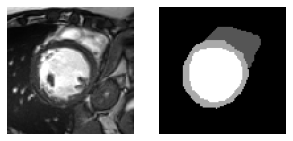

(96, 96)


In [4]:

import os
import cv2 #import OpenCV

data_dir = '/content/drive/MyDrive/data/train/'
image = cv2.imread(os.path.join(data_dir,'image','cmr1.png'), cv2.IMREAD_UNCHANGED)
mask = cv2.imread(os.path.join(data_dir,'mask','cmr1_mask.png'), cv2.IMREAD_UNCHANGED)
show_image_mask(image, mask, cmap='gray')
plt.pause(1)
cv2.imwrite(os.path.join('./','cmr1.png'), mask*85)
print(image.shape)

Note: You will no doubt notice that the mask images appear to be completely black with no sign of any segmentations. This is because the max intensity of pixels in an 8-bit png image is 255 and your image viewer software only sees 255 as white. For those values close to zero, you will only see dark values. This is the case for our masks as the background, the right ventricle, the myocardium, and the left ventricle in each image are 0, 1, 2, and 3, respectively. All of which are close to zero. If we multiply the original mask by 85 and save the result to the directory where this code is, we can see the heart indeed shows up. 

## 2 Define a segmentation model with Pytorch

In this section, we expect you to learn how to:
* Define a Segmentation Model
* Define a DataLoader that inputs images to the Model
* Define training parameters and train the model
* Test the trained model with a new input image

### 2.1 Define a DataLoader

Below we provide you with a dataloader to use in your assigment. You will only need to focus on the development of your model and loss function.



In [5]:

import torch
import torch.utils.data as data
import cv2
import os
from glob import glob
path = '/content/drive/MyDrive/data/train'


class TrainDataset(data.Dataset):
    def __init__(self, root=path):
        super(TrainDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))
        #print(self.img_files)
        self.mask_files = []
        #print(self.img_files)
        for img_path in self.img_files:
            basename = os.path.basename(img_path)
            self.mask_files.append(os.path.join(root,'mask',basename[:-4]+'_mask.png'))
            

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            label = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()    #tensor vlaues for data( image) and label( mask) is returned.

    def __len__(self):
        return len(self.img_files)

class TestDataset(data.Dataset):
    def __init__(self, root=''):
        super(TestDataset, self).__init__()
        self.img_files = glob(os.path.join(root,'image','*.png'))

    def __getitem__(self, index):
            img_path = self.img_files[index]
            data = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
            return torch.from_numpy(data).float()

    def __len__(self):
        return len(self.img_files)


### 2.2 Define a Segmenatation Model

You will need to define your CNN model for segmentation below

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )   

class UNet(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()

        self.dconv_pre = double_conv(1,3)       
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512) 
       # self.dconv_down5 = double_conv(512, 1024)       

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):

        convpre = self.dconv_pre(x) #not maxpooling here
        conv1 = self.dconv_down1(convpre)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        x = self.dconv_down4(x)
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out

class CNNSEG(nn.Module):

    def __init__(self, n_class=4):
        super().__init__()
                
        self.dconv_down1 = double_conv(1, 3)
        self.dconv_down2 = double_conv(3, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)          

        self.maxpool = nn.MaxPool2d(2) #kernel size two..stride = none

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        
        
        
       # self.dconv_up3 = double_conv(256 + 512, 256)
        #self.dconv_up2 = double_conv(128 + 256, 128)
        #self.dconv_up1 = double_conv(128 + 64, 64)
        self.dconv_up4 = double_conv(512+512, 512)
        self.dconv_up3 = double_conv()
        self.dconv_up2 = double_conv(512+512, 512)
        self.dconv_up1 = double_conv(512+512, 512)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 

        conv5 = self.dconv_down5(x)

        x = self.upsample(conv5)        #left with 512 channels and ..becomes 12 * 12
        x = torch.cat([x, conv4], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)   
        
        x = self.dconv_up1(x)
        
        out = self.conv_last(x)
        
        return out


#https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.py

model = UNet() # We can now create a model using your defined segmentation model

In [7]:



model = model.to(device)

model

UNet(
  (dconv_pre): Sequential(
    (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (dconv_down4): Sequential(
    (0): 

In [8]:
from torchsummary import  summary
#help to view the visualisation of the model

summary(model,input_size=(1,96,96))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 96, 96]              30
              ReLU-2            [-1, 3, 96, 96]               0
            Conv2d-3            [-1, 3, 96, 96]              84
              ReLU-4            [-1, 3, 96, 96]               0
            Conv2d-5           [-1, 64, 96, 96]           1,792
              ReLU-6           [-1, 64, 96, 96]               0
            Conv2d-7           [-1, 64, 96, 96]          36,928
              ReLU-8           [-1, 64, 96, 96]               0
         MaxPool2d-9           [-1, 64, 48, 48]               0
           Conv2d-10          [-1, 128, 48, 48]          73,856
             ReLU-11          [-1, 128, 48, 48]               0
           Conv2d-12          [-1, 128, 48, 48]         147,584
             ReLU-13          [-1, 128, 48, 48]               0
        MaxPool2d-14          [-1, 128,

### 2.3 Define a Loss function and optimizer

You will need to define a loss function and an optimizer. torch.nn has a variety of readymade loss functions, although you may wish to create your own instead. torch.optim has a variety of optimizers, it is advised that you use one of these.

In [ ]:

import torch.optim as optim
from torch.optim import lr_scheduler

"""
def dice_loss(pred,target, smooth = 1.):

    pred = pred.contiguous()
    target = target.contiguous()    
    """
    When you call contiguous(), it actually makes a copy of the tensor such that the order of its elements in memory is the same as if it had been created from scratch with the same data.

    Normally you don't need to worry about this. You're generally safe to assume everything will work, and wait until you get a RuntimeError: input is not contiguous where PyTorch expects a contiguous tensor to add a call to contiguous().

    """

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean()


criterion = nn.CrossEntropyLoss()

# so we have two types of loss the dice loss and cross entropy loss

def optimizer():
  return optim.Adam(filter( lambda p:p.requires_grad,model.parameters()),lr=1e-4)

optimizer_ft = optimizer()
def exp_lr_scheduler():
  return lr_scheduler.StepLR(optimizer_ft,step_size=30,gamma=0.1)
"""


### 2.4 Training

As most of you will use CPUs to train the model, expect your models to take **30 minutes to train if not longer depending on network architecture**. To save time, you should not be using all training data until your model is well developed. If you are running your model on a GPU training should be significantly faster. During the training process, you may want to save the checkpoints as follows:

```
# Saving checkpoints for validation/testing
torch.save(model.state_dict(), path)
```
The saved checkpoints can be used to load at a later date for validation and testing. Here we give some example code for training a model. Note that you need to specify the max iterations you want to train the model.

In [9]:
# https://github.com/milesial/Pytorch-UNet/blob/master/utils/dice_score.py

import torch
from torch import Tensor


def dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all batches, or for a single mask
    assert input.size() == target.size()
    if input.dim() == 2 and reduce_batch_first:
        raise ValueError(f'Dice: asked to reduce batch but got tensor without batch dimension (shape {input.shape})')

    if input.dim() == 2 or reduce_batch_first:
        inter = torch.dot(input.reshape(-1), target.reshape(-1))
        sets_sum = torch.sum(input) + torch.sum(target)
        if sets_sum.item() == 0:
            sets_sum = 2 * inter

        return (2 * inter + epsilon) / (sets_sum + epsilon)
    else:
        # compute and average metric for each batch element
        dice = 0
        for i in range(input.shape[0]):
            dice += dice_coeff(input[i, ...], target[i, ...])
        return dice / input.shape[0]


def multiclass_dice_coeff(input: Tensor, target: Tensor, reduce_batch_first: bool = False, epsilon=1e-6):
    # Average of Dice coefficient for all classes
    assert input.size() == target.size()
    dice = 0
    for channel in range(input.shape[1]):
        dice += dice_coeff(input[:, channel, ...], target[:, channel, ...], reduce_batch_first, epsilon)

    return dice / input.shape[1]


def dice_loss(input: Tensor, target: Tensor, multiclass: bool = False):
    # Dice loss (objective to minimize) between 0 and 1
    assert input.size() == target.size()
    fn = multiclass_dice_coeff if multiclass else dice_coeff
    return 1 - fn(input, target, reduce_batch_first=True)


In [30]:
from torch.utils.data import DataLoader
from collections import defaultdict
import time
import argparse
from tqdm import tqdm
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
"""
def print_metrics(metrics, epoch_samples, phase='train'):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))

def calc_loss(pred,target,metrics,bce_weight=0.5) :
    #bce = F.binary_cross_entropy_with_logits(pred,target)

    pred = torch.sigmoid(pred)
    dice = dice_loss(pred,target) 

    #loss = bce * bce_weight + dice * (1 - bce_weight)
    

    metrics['bce'] += 1#bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += 1#loss.data.cpu().numpy() * target.size(0)

    return metrics['loss']
"""
checkpoint_path = "checkpoint.pth"
data_path = '/content/drive/MyDrive/data/train/'
num_workers = 4
batch_size = 4
"""
#what does data loader do?
Dataset stores the samples and their corresponding labels, and 
DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

"""

def train_net(model,
              device,
              epochs: int =5,
              batch_size: int = 1,
              learning_rate: float = 0.001,
              #val_percent: float = 0.1,
              #save_checkpoint: bool = True,
             # img_scale: float = 0.5,
              amp: bool = False
):
#print("training the network...")
# Fetch images and labels.
  model.train()  #funciton of the module superclass ..sets the model to train.
  train_set = TrainDataset(data_path)
  training_data_loader = DataLoader(dataset=train_set, num_workers=num_workers, batch_size=batch_size, shuffle=True)
 # https://github.com/milesial/Pytorch-UNet/blob/master/train.py 

  optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  criterion = nn.CrossEntropyLoss()
  if isinstance(criterion,torch.nn.Module): ##just to be sure that criterion is on the correct device.
    criterion.to(device)
  global_step = 0


  for epoch in range(epochs) :
    #torch.set_grad_enabled(True)
    epoch_samples = 0
    epoch_loss=0
    metrics = defaultdict(float)
    since = time.time()
    with tqdm(len(train_set), desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:     
      for iteration, sample in enumerate(training_data_loader):
          img, mask = sample
          img=img.unsqueeze(0)
          img  = img.to(device = device)
          mask = mask.squeeze(1)
          mask = mask.to(device,dtype = torch.long)

      
          #mask = F.one_hot(mask,4).permute(0,3,1,2).float()
          print(mask.shape)
          """
          torch.cuda.amp and torch provide convenience methods for mixed precision,
          where some operations use the torch.float32 (float) datatype and other operations use torch.float16 (half).
          Some ops, like linear layers and convolutions, are much faster in float16. 
          Other ops, like reductions, often require the dynamic range of float32. 
          Mixed precision tries to match each op to its appropriate datatype.
          """
          #with torch.cuda.amp.autocast(enabled = amp)
          out  = model(img)
          print(out.shape)
          loss = criterion (out,mask) # +dice_loss(F.softmax(out,dim=1).float(),
                                                  #mask,multiclass = True)
    
    # Then write your BACKWARD & OPTIMIZE below
    # Note: Compute Loss and Optimize
    #loss = criterion(out,mask)
    #loss_value = loss.item()
    #train_losses.append(loss_value)
    #loss.backward()
          optimizer.zero_grad(set_to_none=True)
          grad_scaler.scale(loss).backward()
          grad_scaler.step(optimizer)
          grad_scaler.update()

          pbar.update(img.shape[0])
          global_step += 1
          epoch_loss += loss.item()
          #experiment.log({
           #         'train loss': loss.item(),
            #        'step': global_step,
             #       'epoch': epoch
               # })
          print('train loss',loss.item(),' step :',global_step,' epoch :',epoch)
          pbar.set_postfix(**{'loss (batch)': loss.item()})

train_net(model,device)

    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Epoch 1/5: 3img [00:00, 11.21img/s, loss (batch)=0.695]

torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6438510417938232  step : 1  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6946656703948975  step : 2  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 6img [00:00, 12.56img/s, loss (batch)=0.772]

train loss 0.5968152284622192  step : 3  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.49230507016181946  step : 4  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9694870710372925  step : 5  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7720135450363159  step : 6  epoch : 0
torch.Size([1, 96, 96])

Epoch 1/5: 9img [00:00, 14.58img/s, loss (batch)=0.603]


torch.Size([1, 4, 96, 96])
train loss 1.0201952457427979  step : 7  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5857422947883606  step : 8  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6029329895973206  step : 9  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 13img [00:00, 16.46img/s, loss (batch)=0.422]

train loss 0.591218888759613  step : 10  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.545095682144165  step : 11  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9291982650756836  step : 12  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.42232707142829895  step : 13  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 17img [00:01, 16.85img/s, loss (batch)=0.491]

train loss 0.6891436576843262  step : 14  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5934986472129822  step : 15  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6967999339103699  step : 16  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.49143123626708984  step : 17  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 21img [00:01, 17.46img/s, loss (batch)=0.809]

train loss 1.162735939025879  step : 18  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.785862386226654  step : 19  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8109195232391357  step : 20  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8093310594558716  step : 21  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 25img [00:01, 17.88img/s, loss (batch)=0.981]

train loss 0.33611661195755005  step : 22  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4491441547870636  step : 23  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9313198924064636  step : 24  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9805493950843811  step : 25  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 29img [00:01, 17.81img/s, loss (batch)=0.588]

train loss 0.7280109524726868  step : 26  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7078601121902466  step : 27  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5711801052093506  step : 28  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5875945687294006  step : 29  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 33img [00:02, 17.23img/s, loss (batch)=0.818]

train loss 0.6905625462532043  step : 30  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5349653959274292  step : 31  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.693942129611969  step : 32  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.817760169506073  step : 33  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 37img [00:02, 17.33img/s, loss (batch)=0.673]

train loss 0.5982047319412231  step : 34  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6464424729347229  step : 35  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.46406787633895874  step : 36  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6732566356658936  step : 37  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 41img [00:02, 17.31img/s, loss (batch)=0.556]

train loss 0.6210591793060303  step : 38  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8654193878173828  step : 39  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7951979637145996  step : 40  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5561647415161133  step : 41  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 45img [00:02, 17.20img/s, loss (batch)=0.728]

train loss 0.7636830806732178  step : 42  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6609619855880737  step : 43  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7654738426208496  step : 44  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7279043793678284  step : 45  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 50img [00:02, 18.10img/s, loss (batch)=0.669]

train loss 0.6535052061080933  step : 46  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5667465925216675  step : 47  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8924737572669983  step : 48  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6687536239624023  step : 49  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 53img [00:03, 17.78img/s, loss (batch)=1.06] 

train loss 0.6330052614212036  step : 50  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.723712682723999  step : 51  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6216680407524109  step : 52  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0622992515563965  step : 53  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 57img [00:03, 17.85img/s, loss (batch)=0.595]

train loss 0.4335496425628662  step : 54  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5817344188690186  step : 55  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5359121561050415  step : 56  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5951426029205322  step : 57  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 61img [00:03, 18.74img/s, loss (batch)=0.629]

train loss 0.5475419163703918  step : 58  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.44578394293785095  step : 59  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6947718858718872  step : 60  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6293408870697021  step : 61  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 65img [00:03, 18.02img/s, loss (batch)=0.43]

train loss 0.9741518497467041  step : 62  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6498897075653076  step : 63  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8500198721885681  step : 64  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.43003731966018677  step : 65  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 69img [00:04, 17.95img/s, loss (batch)=0.714]

train loss 0.5684306025505066  step : 66  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5869418382644653  step : 67  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9464322328567505  step : 68  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7139907479286194  step : 69  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 73img [00:04, 17.47img/s, loss (batch)=0.628]

train loss 0.7345209121704102  step : 70  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7823855876922607  step : 71  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.662030041217804  step : 72  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6279581785202026  step : 73  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 77img [00:04, 18.13img/s, loss (batch)=0.611]

train loss 0.7081284523010254  step : 74  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5799310803413391  step : 75  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4878925085067749  step : 76  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6112760305404663  step : 77  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 81img [00:04, 17.83img/s, loss (batch)=0.515]

train loss 0.7195420265197754  step : 78  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.45512309670448303  step : 79  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5349054336547852  step : 80  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5151792168617249  step : 81  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 85img [00:04, 17.87img/s, loss (batch)=0.703]

train loss 0.6813637614250183  step : 82  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6102191209793091  step : 83  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.604044497013092  step : 84  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7033961415290833  step : 85  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 89img [00:05, 17.95img/s, loss (batch)=0.362]

train loss 0.7172872424125671  step : 86  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7633435726165771  step : 87  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7650877833366394  step : 88  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.3622044324874878  step : 89  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 93img [00:05, 18.09img/s, loss (batch)=0.814]

train loss 0.6416741013526917  step : 90  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6471021175384521  step : 91  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6793063282966614  step : 92  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8141579627990723  step : 93  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 97img [00:05, 18.71img/s, loss (batch)=0.447]

train loss 0.6257504224777222  step : 94  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6469707489013672  step : 95  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5130510330200195  step : 96  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.44678995013237  step : 97  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 1/5: 100img [00:05, 17.10img/s, loss (batch)=0.681]


train loss 0.42143571376800537  step : 98  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.76920086145401  step : 99  epoch : 0
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6811964511871338  step : 100  epoch : 0


Epoch 2/5: 4img [00:00, 13.51img/s, loss (batch)=0.412]

torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.1151458024978638  step : 101  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6932019591331482  step : 102  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.41160038113594055  step : 103  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 8img [00:00, 16.79img/s, loss (batch)=0.515]

train loss 0.764289915561676  step : 104  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5197246074676514  step : 105  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4394211769104004  step : 106  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5148603916168213  step : 107  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 12img [00:00, 17.39img/s, loss (batch)=0.797]

train loss 0.47776952385902405  step : 108  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6570472717285156  step : 109  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9264455437660217  step : 110  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7966711521148682  step : 111  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 16img [00:00, 17.70img/s, loss (batch)=0.585]

train loss 0.630813717842102  step : 112  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5952606201171875  step : 113  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.1011905670166016  step : 114  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.585123598575592  step : 115  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 20img [00:01, 17.91img/s, loss (batch)=0.623]

train loss 0.6579980850219727  step : 116  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.47703632712364197  step : 117  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5418261885643005  step : 118  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6228418946266174  step : 119  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 24img [00:01, 17.81img/s, loss (batch)=0.555]

train loss 0.7065775990486145  step : 120  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9260182976722717  step : 121  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6731253862380981  step : 122  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5545694231987  step : 123  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 28img [00:01, 17.84img/s, loss (batch)=0.691]

train loss 0.7011877298355103  step : 124  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5781654715538025  step : 125  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6013159155845642  step : 126  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.690663754940033  step : 127  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 32img [00:01, 17.96img/s, loss (batch)=0.668]

train loss 0.3498602509498596  step : 128  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.45974573493003845  step : 129  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8286783695220947  step : 130  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6679575443267822  step : 131  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 35img [00:02, 17.63img/s, loss (batch)=0.707]

train loss 0.7272307872772217  step : 132  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9478736519813538  step : 133  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8449164032936096  step : 134  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7072376608848572  step : 135  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 40img [00:02, 17.75img/s, loss (batch)=0.433]

train loss 0.5572407841682434  step : 136  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6871941089630127  step : 137  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9102767109870911  step : 138  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.43282270431518555  step : 139  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 44img [00:02, 18.09img/s, loss (batch)=0.635]

train loss 0.4777947664260864  step : 140  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5050100684165955  step : 141  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5492743253707886  step : 142  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6351413726806641  step : 143  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 48img [00:02, 18.08img/s, loss (batch)=0.567]

train loss 0.9721076488494873  step : 144  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4232288599014282  step : 145  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.665012776851654  step : 146  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5673664212226868  step : 147  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 51img [00:02, 17.81img/s, loss (batch)=0.687]

train loss 0.4405132830142975  step : 148  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7374024391174316  step : 149  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7830955982208252  step : 150  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6871940493583679  step : 151  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 56img [00:03, 18.28img/s, loss (batch)=1]

train loss 0.7118975520133972  step : 152  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5850857496261597  step : 153  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5503928065299988  step : 154  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0048229694366455  step : 155  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 60img [00:03, 18.07img/s, loss (batch)=1.02]

train loss 0.82277911901474  step : 156  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7288563251495361  step : 157  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.564124345779419  step : 158  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.018275260925293  step : 159  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 64img [00:03, 18.07img/s, loss (batch)=0.6]

train loss 0.39059653878211975  step : 160  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6420031785964966  step : 161  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5893640518188477  step : 162  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5996523499488831  step : 163  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 68img [00:03, 18.02img/s, loss (batch)=0.617]

train loss 0.643677294254303  step : 164  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7513494491577148  step : 165  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7118046879768372  step : 166  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6172485947608948  step : 167  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 71img [00:04, 17.24img/s, loss (batch)=0.645]

train loss 0.6037414073944092  step : 168  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5239608287811279  step : 169  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6567661166191101  step : 170  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6454194188117981  step : 171  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 75img [00:04, 17.67img/s, loss (batch)=0.456]

train loss 0.9114606380462646  step : 172  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7890447974205017  step : 173  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5296298265457153  step : 174  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.455609530210495  step : 175  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 80img [00:04, 17.93img/s, loss (batch)=0.668]

train loss 0.7761415839195251  step : 176  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6899056434631348  step : 177  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5807075500488281  step : 178  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6678842902183533  step : 179  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 83img [00:04, 17.71img/s, loss (batch)=0.829]

train loss 0.5587568283081055  step : 180  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7121932506561279  step : 181  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7712461948394775  step : 182  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8290226459503174  step : 183  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 87img [00:04, 17.72img/s, loss (batch)=0.586]

train loss 0.7288993000984192  step : 184  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7750042676925659  step : 185  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7629778981208801  step : 186  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.586230993270874  step : 187  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 92img [00:05, 17.80img/s, loss (batch)=0.645]

train loss 0.41076457500457764  step : 188  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7494474053382874  step : 189  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6119992733001709  step : 190  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6454344391822815  step : 191  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 96img [00:05, 18.50img/s, loss (batch)=0.622]

train loss 0.681948721408844  step : 192  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.750867486000061  step : 193  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6869090795516968  step : 194  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6221928000450134  step : 195  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 2/5: 100img [00:05, 18.67img/s, loss (batch)=0.518]

train loss 0.6054723262786865  step : 196  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6124274730682373  step : 197  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6439778804779053  step : 198  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7131227850914001  step : 199  epoch : 1
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5181896686553955  step : 200  epoch : 1


Epoch 2/5: 100img [00:05, 17.41img/s, loss (batch)=0.518]
Epoch 3/5: 4img [00:00, 13.97img/s, loss (batch)=0.705]

torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7925395369529724  step : 201  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8227136135101318  step : 202  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7053295969963074  step : 203  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 8img [00:00, 16.14img/s, loss (batch)=0.642]

train loss 0.6113808155059814  step : 204  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.021154522895813  step : 205  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5660864114761353  step : 206  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6424806118011475  step : 207  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 12img [00:00, 17.14img/s, loss (batch)=0.731]

train loss 0.5578098297119141  step : 208  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.42326095700263977  step : 209  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.587708592414856  step : 210  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7305965423583984  step : 211  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 15img [00:00, 18.11img/s, loss (batch)=0.708]

train loss 0.668737530708313  step : 212  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6279212236404419  step : 213  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5276517868041992  step : 214  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7076507210731506  step : 215  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 19img [00:01, 17.96img/s, loss (batch)=0.954]

train loss 0.5570912957191467  step : 216  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.37551212310791016  step : 217  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.41308653354644775  step : 218  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.95401531457901  step : 219  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 23img [00:01, 18.06img/s, loss (batch)=0.954]

train loss 0.7779411673545837  step : 220  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.779683530330658  step : 221  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7893550992012024  step : 222  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9543484449386597  step : 223  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 27img [00:01, 18.27img/s, loss (batch)=0.835]

train loss 0.6911605000495911  step : 224  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7264077067375183  step : 225  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9197052717208862  step : 226  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8353418707847595  step : 227  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 31img [00:01, 18.22img/s, loss (batch)=0.605]

train loss 0.531235933303833  step : 228  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0606646537780762  step : 229  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.749299168586731  step : 230  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6050974726676941  step : 231  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 35img [00:02, 17.48img/s, loss (batch)=0.676]

train loss 0.4956530034542084  step : 232  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6370257139205933  step : 233  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6190760135650635  step : 234  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6762588024139404  step : 235  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 39img [00:02, 18.03img/s, loss (batch)=0.523]

train loss 0.7069981694221497  step : 236  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5050733685493469  step : 237  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6412135362625122  step : 238  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5231256484985352  step : 239  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 43img [00:02, 18.01img/s, loss (batch)=0.914]

train loss 0.6951574087142944  step : 240  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7957872748374939  step : 241  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.729129433631897  step : 242  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9140906929969788  step : 243  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 47img [00:02, 17.89img/s, loss (batch)=0.785]

train loss 0.5920207500457764  step : 244  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5687413811683655  step : 245  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5751360058784485  step : 246  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7848541736602783  step : 247  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 51img [00:02, 17.81img/s, loss (batch)=0.431]

train loss 0.41444212198257446  step : 248  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4595828652381897  step : 249  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9846094846725464  step : 250  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4305514097213745  step : 251  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 55img [00:03, 17.10img/s, loss (batch)=0.715]

train loss 0.7222954630851746  step : 252  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.3834957182407379  step : 253  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7314567565917969  step : 254  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7151170372962952  step : 255  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 60img [00:03, 17.90img/s, loss (batch)=1.01]

train loss 0.3113870322704315  step : 256  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8300029635429382  step : 257  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5106085538864136  step : 258  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.012397289276123  step : 259  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 63img [00:03, 18.09img/s, loss (batch)=0.581]

train loss 0.5065863132476807  step : 260  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5254505276679993  step : 261  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7635442018508911  step : 262  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5814633965492249  step : 263  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 68img [00:03, 17.77img/s, loss (batch)=0.542]

train loss 0.5775026679039001  step : 264  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9245198369026184  step : 265  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6159178614616394  step : 266  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5421882271766663  step : 267  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 71img [00:04, 17.55img/s, loss (batch)=0.656]

train loss 0.5761001110076904  step : 268  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6490528583526611  step : 269  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5589170455932617  step : 270  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6556313037872314  step : 271  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 75img [00:04, 17.64img/s, loss (batch)=0.701]

train loss 0.63556307554245  step : 272  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6518159508705139  step : 273  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4727591276168823  step : 274  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7014252543449402  step : 275  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 80img [00:04, 17.77img/s, loss (batch)=0.669]

train loss 0.6373922824859619  step : 276  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7389299869537354  step : 277  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.45421159267425537  step : 278  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6693013906478882  step : 279  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 84img [00:04, 18.18img/s, loss (batch)=0.841]

train loss 0.6500949859619141  step : 280  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.43342316150665283  step : 281  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6876429915428162  step : 282  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8405061364173889  step : 283  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 88img [00:04, 18.27img/s, loss (batch)=0.687]

train loss 0.6746760606765747  step : 284  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.646827220916748  step : 285  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7492302656173706  step : 286  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6869710683822632  step : 287  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 92img [00:05, 18.64img/s, loss (batch)=0.69]

train loss 0.5070860981941223  step : 288  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6148415207862854  step : 289  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7704858779907227  step : 290  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6904911398887634  step : 291  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 96img [00:05, 18.75img/s, loss (batch)=0.601]

train loss 0.6168171763420105  step : 292  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5338858962059021  step : 293  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7690823674201965  step : 294  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6009988188743591  step : 295  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 99img [00:05, 18.44img/s, loss (batch)=0.725]

train loss 1.090423345565796  step : 296  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6921937465667725  step : 297  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6040516495704651  step : 298  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7247669696807861  step : 299  epoch : 2
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 3/5: 100img [00:05, 17.44img/s, loss (batch)=0.594]


train loss 0.5941804647445679  step : 300  epoch : 2


Epoch 4/5: 4img [00:00, 13.47img/s, loss (batch)=0.701]

torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6467037796974182  step : 301  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.653503954410553  step : 302  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7012274861335754  step : 303  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 8img [00:00, 16.90img/s, loss (batch)=0.718]

train loss 0.5869089961051941  step : 304  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9028087258338928  step : 305  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5706942081451416  step : 306  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7175732851028442  step : 307  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 11img [00:00, 17.04img/s, loss (batch)=1.09] 

train loss 0.9228506088256836  step : 308  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6172279715538025  step : 309  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5345675945281982  step : 310  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0857058763504028  step : 311  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 15img [00:00, 18.41img/s, loss (batch)=0.761]

train loss 0.6068087816238403  step : 312  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6238263249397278  step : 313  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6123243570327759  step : 314  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7605526447296143  step : 315  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 19img [00:01, 18.14img/s, loss (batch)=0.566]

train loss 0.7118103504180908  step : 316  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6704169511795044  step : 317  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.674505352973938  step : 318  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5664889812469482  step : 319  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 23img [00:01, 17.45img/s, loss (batch)=0.598]

train loss 0.5334361791610718  step : 320  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7673743963241577  step : 321  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.44325026869773865  step : 322  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5984205007553101  step : 323  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 27img [00:01, 18.28img/s, loss (batch)=0.711]

train loss 0.44930893182754517  step : 324  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5925124883651733  step : 325  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4570145010948181  step : 326  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7109130024909973  step : 327  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 31img [00:01, 18.40img/s, loss (batch)=0.404]

train loss 0.57343989610672  step : 328  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6995823383331299  step : 329  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.3601967692375183  step : 330  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.40390801429748535  step : 331  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 35img [00:02, 17.85img/s, loss (batch)=0.302]

train loss 0.6785990595817566  step : 332  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5123958587646484  step : 333  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5007174015045166  step : 334  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.3020712435245514  step : 335  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 39img [00:02, 18.58img/s, loss (batch)=0.825]

train loss 0.8187071681022644  step : 336  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.711190938949585  step : 337  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4546775817871094  step : 338  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8253804445266724  step : 339  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 43img [00:02, 18.33img/s, loss (batch)=0.696]

train loss 0.4045131504535675  step : 340  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.1589078903198242  step : 341  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8058866858482361  step : 342  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6955090761184692  step : 343  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 47img [00:02, 17.49img/s, loss (batch)=0.49] 

train loss 0.9632197618484497  step : 344  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5879635810852051  step : 345  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6269777417182922  step : 346  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.48975732922554016  step : 347  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 51img [00:02, 18.00img/s, loss (batch)=0.674]

train loss 0.9541712999343872  step : 348  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8181287050247192  step : 349  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7414654493331909  step : 350  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6744563579559326  step : 351  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 55img [00:03, 18.26img/s, loss (batch)=0.69] 

train loss 0.5901658535003662  step : 352  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.726599395275116  step : 353  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6805631518363953  step : 354  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6903120875358582  step : 355  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 59img [00:03, 18.11img/s, loss (batch)=0.639]

train loss 0.5459611415863037  step : 356  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7321622371673584  step : 357  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6967552304267883  step : 358  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6390032768249512  step : 359  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 63img [00:03, 18.14img/s, loss (batch)=1.51]

train loss 0.908659815788269  step : 360  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5870689749717712  step : 361  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0947884321212769  step : 362  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.5113645792007446  step : 363  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 67img [00:03, 18.03img/s, loss (batch)=0.574]

train loss 1.014549970626831  step : 364  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7261248826980591  step : 365  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4619736671447754  step : 366  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5741860866546631  step : 367  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 71img [00:04, 17.84img/s, loss (batch)=0.851]

train loss 0.39368247985839844  step : 368  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9466722011566162  step : 369  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.680314302444458  step : 370  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8513364195823669  step : 371  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 75img [00:04, 17.51img/s, loss (batch)=0.89] 

train loss 0.8436269760131836  step : 372  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9238436818122864  step : 373  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.644810676574707  step : 374  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.890099823474884  step : 375  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 79img [00:04, 17.31img/s, loss (batch)=1.04] 

train loss 0.9698988795280457  step : 376  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.988586962223053  step : 377  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9547801613807678  step : 378  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.035322666168213  step : 379  epoch : 3
torch.Size([1, 96, 96])


Epoch 4/5: 83img [00:04, 17.00img/s, loss (batch)=0.994]

torch.Size([1, 4, 96, 96])
train loss 0.7072311043739319  step : 380  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0506757497787476  step : 381  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9941064119338989  step : 382  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.766552209854126  step : 383  epoch : 3


Epoch 4/5: 87img [00:04, 17.11img/s, loss (batch)=0.416]

torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7688314318656921  step : 384  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5446910262107849  step : 385  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4159322679042816  step : 386  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 90img [00:05, 17.31img/s, loss (batch)=0.852]

train loss 1.0600037574768066  step : 387  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.810700535774231  step : 388  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8634594678878784  step : 389  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8519453406333923  step : 390  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 95img [00:05, 17.68img/s, loss (batch)=0.727]

train loss 0.6942043900489807  step : 391  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.712177038192749  step : 392  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9419975280761719  step : 393  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7274805903434753  step : 394  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 99img [00:05, 18.42img/s, loss (batch)=0.527]

train loss 0.5785682201385498  step : 395  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7269585132598877  step : 396  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6502510905265808  step : 397  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5271408557891846  step : 398  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 4/5: 100img [00:05, 17.29img/s, loss (batch)=0.664]


train loss 0.7202596664428711  step : 399  epoch : 3
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6636773347854614  step : 400  epoch : 3


Epoch 5/5: 3img [00:00, 12.27img/s, loss (batch)=0.558]

torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7773511409759521  step : 401  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5298402309417725  step : 402  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5580921173095703  step : 403  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 7img [00:00, 16.26img/s, loss (batch)=0.716]

train loss 0.8844360113143921  step : 404  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8138084411621094  step : 405  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7447802424430847  step : 406  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7156400680541992  step : 407  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 11img [00:00, 16.69img/s, loss (batch)=0.651]

train loss 0.9391549229621887  step : 408  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6733803749084473  step : 409  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6484547853469849  step : 410  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6509281992912292  step : 411  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 15img [00:00, 17.35img/s, loss (batch)=0.78] 

train loss 0.6093398928642273  step : 412  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5745619535446167  step : 413  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6219817399978638  step : 414  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7799108028411865  step : 415  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 19img [00:01, 17.65img/s, loss (batch)=0.511]

train loss 0.7512611746788025  step : 416  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7169779539108276  step : 417  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4310930669307709  step : 418  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5108281373977661  step : 419  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 23img [00:01, 18.22img/s, loss (batch)=1.07] 

train loss 0.46383535861968994  step : 420  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.45782968401908875  step : 421  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7358335852622986  step : 422  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0679051876068115  step : 423  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 27img [00:01, 18.58img/s, loss (batch)=0.754]

train loss 0.6532850861549377  step : 424  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7363205552101135  step : 425  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9284335374832153  step : 426  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7544572353363037  step : 427  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 31img [00:01, 18.15img/s, loss (batch)=0.397]

train loss 0.4698801636695862  step : 428  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7048092484474182  step : 429  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6585182547569275  step : 430  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.39671456813812256  step : 431  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 35img [00:02, 17.55img/s, loss (batch)=0.693]

train loss 0.6416807174682617  step : 432  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.3901745080947876  step : 433  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5505506992340088  step : 434  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6934038996696472  step : 435  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 39img [00:02, 17.59img/s, loss (batch)=0.708]

train loss 0.7248024940490723  step : 436  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7586419582366943  step : 437  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7269956469535828  step : 438  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7077383399009705  step : 439  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 43img [00:02, 18.38img/s, loss (batch)=0.564]

train loss 0.7218592762947083  step : 440  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6643608212471008  step : 441  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7089627385139465  step : 442  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.564433217048645  step : 443  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 47img [00:02, 18.54img/s, loss (batch)=0.711]

train loss 0.5622143149375916  step : 444  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5536239147186279  step : 445  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6352813243865967  step : 446  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7111790776252747  step : 447  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 51img [00:02, 18.41img/s, loss (batch)=0.636]

train loss 0.6263488531112671  step : 448  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5180514454841614  step : 449  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5919890403747559  step : 450  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6357667446136475  step : 451  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 55img [00:03, 17.76img/s, loss (batch)=0.579]

train loss 0.4121493697166443  step : 452  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8668404817581177  step : 453  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5798028111457825  step : 454  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5790782570838928  step : 455  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 59img [00:03, 18.02img/s, loss (batch)=0.753]

train loss 0.5296903252601624  step : 456  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5145256519317627  step : 457  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6491400003433228  step : 458  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7531185746192932  step : 459  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 63img [00:03, 17.92img/s, loss (batch)=0.465]

train loss 0.5783160328865051  step : 460  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5991001129150391  step : 461  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 1.0594719648361206  step : 462  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.46458113193511963  step : 463  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 67img [00:03, 17.92img/s, loss (batch)=0.747]

train loss 0.8866493105888367  step : 464  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6057164669036865  step : 465  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4782455265522003  step : 466  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7474954128265381  step : 467  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 71img [00:04, 17.95img/s, loss (batch)=0.584]

train loss 0.6800188422203064  step : 468  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9305846095085144  step : 469  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5327770113945007  step : 470  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5837606191635132  step : 471  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 75img [00:04, 17.75img/s, loss (batch)=0.658]

train loss 0.9943773746490479  step : 472  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7600017189979553  step : 473  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.563835859298706  step : 474  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6576111912727356  step : 475  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 79img [00:04, 17.84img/s, loss (batch)=0.449]

train loss 0.7932460904121399  step : 476  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.769865095615387  step : 477  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7398115992546082  step : 478  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.4488793611526489  step : 479  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 83img [00:04, 17.79img/s, loss (batch)=0.91] 

train loss 0.8285146355628967  step : 480  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6618466973304749  step : 481  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6782601475715637  step : 482  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9102939963340759  step : 483  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 87img [00:04, 17.74img/s, loss (batch)=0.574]

train loss 0.6963851451873779  step : 484  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6939334273338318  step : 485  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5977579951286316  step : 486  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.5743594169616699  step : 487  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 91img [00:05, 18.09img/s, loss (batch)=0.787]

train loss 0.8274158239364624  step : 488  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.70320725440979  step : 489  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7030025720596313  step : 490  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7870851159095764  step : 491  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 95img [00:05, 18.46img/s, loss (batch)=0.764]

train loss 0.7801429033279419  step : 492  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.9169502258300781  step : 493  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7231762409210205  step : 494  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.7642805576324463  step : 495  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 99img [00:05, 18.34img/s, loss (batch)=0.658]

train loss 1.0468775033950806  step : 496  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.8090575337409973  step : 497  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6354923248291016  step : 498  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])
train loss 0.6583325266838074  step : 499  epoch : 4
torch.Size([1, 96, 96])
torch.Size([1, 4, 96, 96])


Epoch 5/5: 100img [00:05, 17.40img/s, loss (batch)=0.66]

train loss 0.6598200798034668  step : 500  epoch : 4


### 2.5 Testing

When validating the trained checkpoints (models), remember to change the model status as **Evaluation Mode**

In [ ]:
import numpy as np
from torch.autograd import Variable

In [ ]:
# In this block you are expected to write code to load saved model and deploy it to all data in test set to 
# produce segmentation masks in png images valued 0,1,2,3, which will be used for the submission to Kaggle.
data_path = './data/test'
num_workers = 4
batch_size = 2

test_set = TestDataset(data_path)
test_data_loader = DataLoader(dataset=test_set, num_workers=num_workers,batch_size=batch_size, shuffle=False)

for iteration, sample in enumerate(test_data_loader):
    img = sample
    print(img.shape)

    plt.imshow(img[0,...].squeeze(), cmap='gray') #visualise all images in test set
    plt.pause(1)

## 3 Evaluation

As we will automatically evaluate your predicted test makes on Kaggle, in this section we expect you to learn:
* what is the Dice score used on Kaggle to measure your models performance
* how to submit your predicted masks to Kaggle

### 3.1 Dice Score

To evaluate the quality of the predicted masks, the Dice score is adopted. Dice score on two masks A and B is defined as the intersection ratio between the overlap area and the average area of two masks. A higher Dice suggests a better registration.

$Dice (A, B)= \frac{2|A \cap B|}{|A| + |B|} $

However, in our coursework, we have three labels in each mask, we will compute the Dice score for each label and then average the three of them as the final score. Below we have given you `categorical_dice` for free so you can test your results before submission to Kaggle.

In [ ]:
def categorical_dice(mask1, mask2, label_class=1):
    """
    Dice score of a specified class between two volumes of label masks.
    (classes are encoded but by label class number not one-hot )
    Note: stacks of 2D slices are considered volumes.

    Args:
        mask1: N label masks, numpy array shaped (H, W, N)
        mask2: N label masks, numpy array shaped (H, W, N)
        label_class: the class over which to calculate dice scores

    Returns:
        volume_dice
    """
    mask1_pos = (mask1 == label_class).astype(np.float32)
    mask2_pos = (mask2 == label_class).astype(np.float32)
    dice = 2 * np.sum(mask1_pos * mask2_pos) / (np.sum(mask1_pos) + np.sum(mask2_pos))
    return dice

### 3.2 Submission

Kaggle requires your submission to be in a specific CSV format. To help ensure your submissions are in the correct format, we have provided some helper functions to do this for you. For those interested, the png images are run-length encoded and saved in a CSV to the specifications required by our competition.

It is sufficient to use this helper function. To do so, save your 80 predicted masks into a directory. ONLY the 80 predicted masks should be in this directory. Call the submission_converter function with the first argument as the directory containing your masks, and the second the directory in which you wish to save your submission.

In [ ]:
import numpy as np
import os
import cv2

def rle_encoding(x):
    '''
    *** Credit to https://www.kaggle.com/rakhlin/fast-run-length-encoding-python ***
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths


def submission_converter(mask_directory, path_to_save):
    writer = open(os.path.join(path_to_save, "submission.csv"), 'w')
    writer.write('id,encoding\n')

    files = os.listdir(mask_directory)

    for file in files:
        name = file[:-4]
        mask = cv2.imread(os.path.join(mask_directory, file), cv2.IMREAD_UNCHANGED)

        mask1 = (mask == 1)
        mask2 = (mask == 2)
        mask3 = (mask == 3)

        encoded_mask1 = rle_encoding(mask1)
        encoded_mask1 = ' '.join(str(e) for e in encoded_mask1)
        encoded_mask2 = rle_encoding(mask2)
        encoded_mask2 = ' '.join(str(e) for e in encoded_mask2)
        encoded_mask3 = rle_encoding(mask3)
        encoded_mask3 = ' '.join(str(e) for e in encoded_mask3)

        writer.write(name + '1,' + encoded_mask1 + "\n")
        writer.write(name + '2,' + encoded_mask2 + "\n")
        writer.write(name + '3,' + encoded_mask3 + "\n")

    writer.close()